## Data challenge2: Pricing Test

#### Challenge Description


Company XYZ sells a software for 39 dollars. Since revenue has been flat for some time, the VP of Product has decided to run a test increasing the price. She hopes that this would increase revenue. In the experiment, 66% of the users have seen the old price (39 dollars), while a random sample of 33% users a higher price (59 dollars).


The test has been running for some time and the VP of Product is interested in understanding how it went and whether it would make sense to increase the price for all the users.


Especially he asked you the following questions:


Should the company sell its software for 39 or 59 dollars?


The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. What are your main findings looking at the data?


The VP of Product feels that the test has been running for too long and he should have been able to get statistically significant results in a shorter time. Do you agree with her intuition? After how many days you would have stopped the test? Please, explain why.



In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
color = sns.color_palette()
%matplotlib inline

In [68]:
test_result =  pd.read_csv("../test_results.csv")
user_table = pd.read_csv("../user_table.csv")

In [69]:
test_result.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [70]:
#Lets remove the rows which are mislabelled, for test=1 the price should be 59
test_result = test_result[~((test_result.price==39) & (test_result.test==1))]
#for test =0 price should be 39
test_result = test_result[~((test_result.price==59) & (test_result.test==0))]

In [71]:
#Lets get some basics stats.

NA = len(test_result[(test_result.price==39)]) # number of people who saw price of $39
nA = len(test_result[(test_result.price==39) &(test_result.converted)==1]) # number of people who converted at price $39

NB = len(test_result[(test_result.price==59)])
nB = len(test_result[(test_result.price==59) &(test_result.converted)==1])

pA = nA/NA # fraction of control group who converted 
pB = nB/NB # fraction of test group who converted 

print("NA = %d\n nA = %d\n NB = %d\n nB = %d" % (NA, nA, NB, nB))
print("pA = %f, pB = %f" % (pA, pB))

NA = 202517
 nA = 4030
 NB = 113918
 nB = 1772
pA = 0.019900, pB = 0.015555


Each click is a Bernoulli trail with pA being probability of someone converting. 
For large NA, pA is approx normally distributed with sigmaA = sqrt(pA*(1-pA)/NA). 
Similarly for case B

In [72]:
sigmaA = np.sqrt(pA*(1-pA)/NA)
sigmaB = np.sqrt(pB*(1-pB)/NB)

Since these two cases are independent, their difference should be normally distributed with mean = pA - pB and std. deviation as sqrt(sigmaA^2+sigmaB^2)

In [73]:
# Our null hypothesis is that there is no difference between these two conversion rates
mu = pB - pA
std_dev =  np.sqrt(sigmaA**2+sigmaB**2)

In [74]:
z_score = mu/std_dev
print(z_score)

-9.04464086682


This gives a p-value of really really small..very close to zero. So we can reject the null hypothesis and conclude that conversion ratio of test cases is significant

In [75]:
data = pd.merge(test_result, user_table, on = 'user_id')

In [76]:
data.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02


In [77]:
df_os_39 = data[data.price==39].groupby("operative_system")["converted"].value_counts(normalize=True).rename("frac_conv").reset_index()
df_os_59 = data[data.price==59].groupby("operative_system")["converted"].value_counts(normalize=True).rename("frac_conv").reset_index()

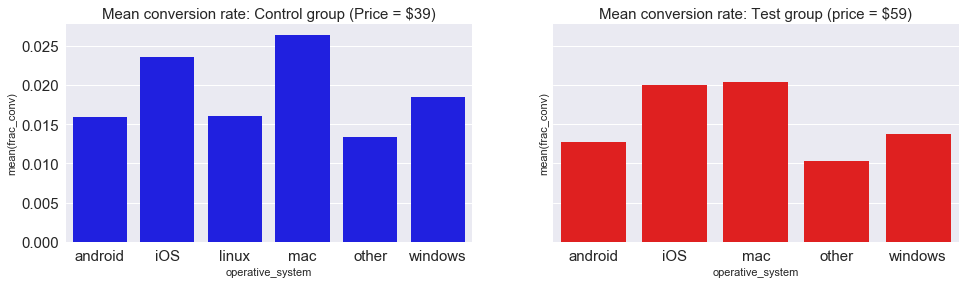

In [229]:
fig, ax =plt.subplots(1,2, sharey=True, figsize=(16,4))
sns.barplot(x='operative_system', y='frac_conv', data=df_os_39[df_os_39.converted==1], ax=ax[0], palette=['blue'])
ax[0].set_title("Mean conversion rate: Control group (Price = $39)", size=15)
ax[0].tick_params(labelsize=15)
sns.barplot(x='operative_system', y='frac_conv', data=df_os_59[df_os_59.converted==1], ax=ax[1], palette=['red'])
ax[1].set_title("Mean conversion rate: Test group (price = $59)", size=15)
ax[1].tick_params(labelsize=15)
plt.show()

In [79]:
df_dev_39 = data[data.price==39].groupby("device")["converted"].value_counts(normalize=True).rename("frac_conv").reset_index()
df_dev_59 = data[data.price==59].groupby("device")["converted"].value_counts(normalize=True).rename("frac_conv").reset_index()

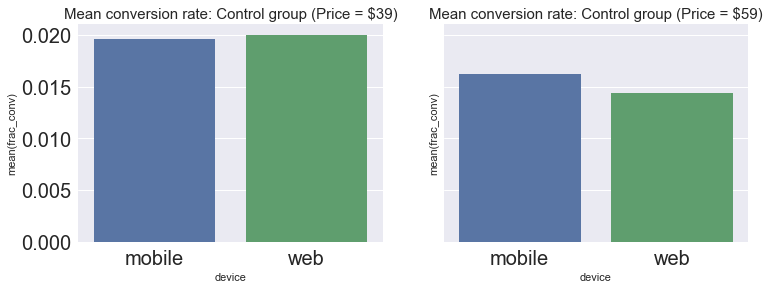

In [231]:
fig, ax =plt.subplots(1,2, sharey=True, figsize=(12,4))
sns.barplot(x='device', y='frac_conv', data=df_dev_39[df_dev_39.converted==1], ax=ax[0])
ax[0].set_title("Mean conversion rate: Control group (Price = $39)", size=15)
ax[0].tick_params(labelsize=20)
sns.barplot(x='device', y='frac_conv', data=df_dev_59[df_dev_59.converted==1], ax=ax[1])
ax[1].set_title("Mean conversion rate: Control group (Price = $59)", size=15)
ax[1].tick_params(labelsize=20)
plt.show()

It looks the rate of converting from the non-mobile device (web) for price of 59 is lower than mobile device.
For the price of $39 the rate is more or less equal regardless of device used

In [81]:
df_sou_39 = data[data.price==39].groupby("source")["converted"].value_counts(normalize=True).rename("frac_conv").reset_index()
df_sou_59 = data[data.price==59].groupby("source")["converted"].value_counts(normalize=True).rename("frac_conv").reset_index()

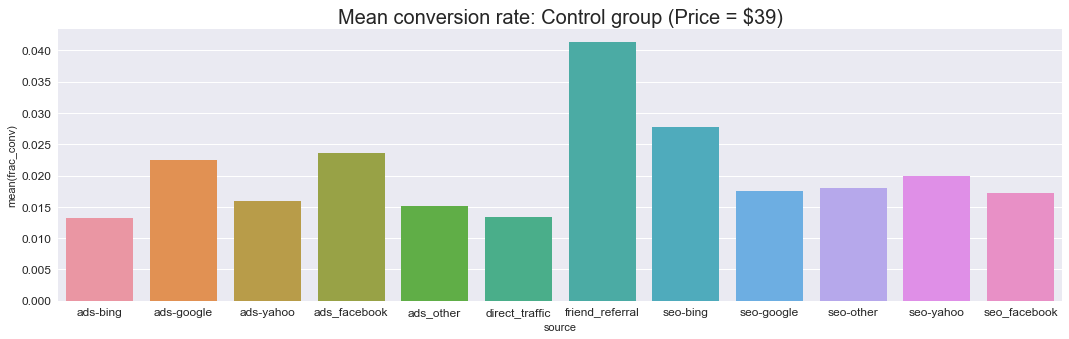

In [232]:
plt.figure(figsize=(18,5))
sns.barplot(x='source', y='frac_conv', data=df_sou_39[df_sou_39.converted==1])
plt.title("Mean conversion rate: Control group (Price = $39)", size=20)
plt.tick_params(labelsize=12)

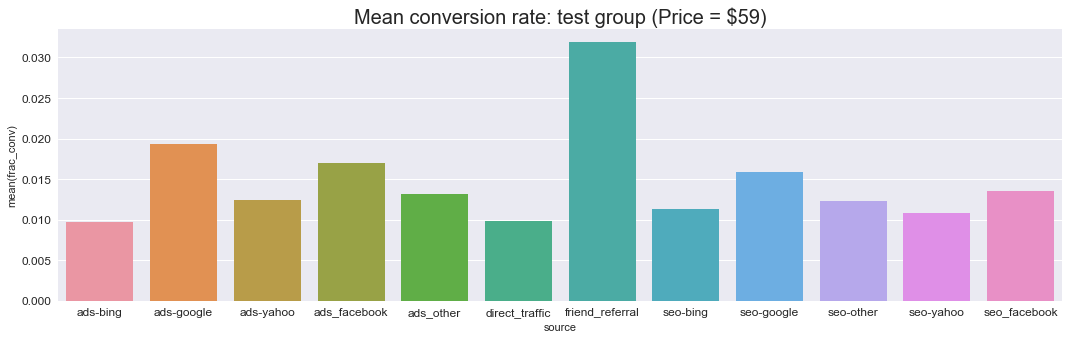

In [234]:
plt.figure(figsize=(18,5))
sns.barplot(x='source', y='frac_conv', data=df_sou_59[df_sou_59.converted==1])
plt.title("Mean conversion rate: test group (Price = $59)", size=20)
plt.tick_params(labelsize=12)

In [84]:
df_cit_39 = data[data.price==39].groupby("city")["converted"].value_counts(normalize=True).rename("frac_conv").reset_index()
df_cit_59 = data[data.price==59].groupby("city")["converted"].value_counts(normalize=True).rename("frac_conv").reset_index()

In [85]:
data.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02


In [101]:
# timestamp seems to have some issues -  sometimes minutes and seconds become 60 instead of rolling to next min or sec after 59.
# Here we replace all 60s with 59..so there will be an offset of 1 min or 1 sec for each of those cases. 
# This offset is probabily not very important

def new_min(row):
    if ':60:' in row:
        row = row.replace('60', '59')
    elif ':60' in row:
        row = row.replace('60', '59')
    else:
        row = row
    return row

data["timestamp"] = data["timestamp"].apply(new_min)

In [118]:
data["timestamp"] = pd.to_datetime(data["timestamp"])

In [122]:
data["date"] = pd.to_datetime(data["timestamp"]).dt.date

In [125]:
data["time"] = pd.to_datetime(data["timestamp"]).dt.time

In [126]:
data.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long,date,time
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86,2015-05-08,03:38:34
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24,2015-05-10,21:08:46
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73,2015-04-04,15:01:23
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90,2015-05-07,07:26:01
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02,2015-05-24,11:04:40


In [131]:
data["date"].max()

datetime.date(2015, 5, 31)

In [133]:
data["date"].min()

datetime.date(2015, 3, 2)

In [168]:
df["day"] = pd.to_datetime(df["day"]).dt.date

In [170]:
df.head()

,day
0,2015-03-02
1,2015-03-03
2,2015-03-04
3,2015-03-05
4,2015-03-06


In [135]:
df = pd.DataFrame(pd.date_range(start='2015-3-2', end='2015-5-31', freq='D'), columns=["day"])

In [173]:
def get_frac39(row):
    frac39 = len(data[((data.price==39) & (data.converted)==1) & (data.date == row["day"])]) / len(data[(data.price==39) & (data.date == row["day"])]) 
    return frac39

def get_frac59(row):
    frac59 = len(data[((data.price==59) & (data.converted)==1) & (data.date == row["day"])]) / len(data[(data.price==59) & (data.date == row["day"])]) 
    return frac59


In [185]:
# add conversion ratio for test and control group
df["frac39"] = df.apply(get_frac39, axis=1)
df["frac59"] = df.apply(get_frac59, axis=1)

In [189]:
# add cumulative mean of conversion ratio to each day 
df["frac39"] = df['frac39'].expanding().mean()
df["frac59"] = df['frac59'].expanding().mean()

In [190]:
df.head()

,day,frac39,frac59
0,2015-03-02,0.016988,0.015905
1,2015-03-03,0.020222,0.011960
2,2015-03-04,0.023167,0.010531
3,2015-03-05,0.023928,0.013693
4,2015-03-06,0.022997,0.014604


In [193]:
def get_num39_converted(row):
    num39_conv = len(data[((data.price==39) & (data.converted)==1) & (data.date == row["day"])])
    return num39_conv

def get_num59_converted(row):
    num59_conv = len(data[((data.price==59) & (data.converted)==1) & (data.date == row["day"])])
    return num59_conv

def get_num39_notconverted(row):
    num39_notconv = len(data[((data.price==39) & (data.converted)==0) & (data.date == row["day"])])
    return num39_notconv

def get_num59_notconverted(row):
    num59_notconv = len(data[((data.price==59) & (data.converted)==0) & (data.date == row["day"])])
    return num59_notconv


In [194]:
df["num39_converted"] = df.apply(get_num39_converted, axis=1)
df["num59_converted"] = df.apply(get_num59_converted, axis=1)
df["num39_notconverted"] = df.apply(get_num39_notconverted, axis=1)
df["num59_notconverted"] = df.apply(get_num59_notconverted, axis=1)

In [225]:
df.head()

,day,frac39,frac59,num39_converted,num59_converted,num39_notconverted,num59_notconverted
0,2015-03-02,0.016988,0.015905,15,8,1371,1378
1,2015-03-03,0.020222,0.011960,19,4,1290,1305
2,2015-03-04,0.023167,0.010531,24,3,1193,1214
3,2015-03-05,0.023928,0.013693,40,21,2392,2411
4,2015-03-06,0.022997,0.014604,77,41,6165,6201


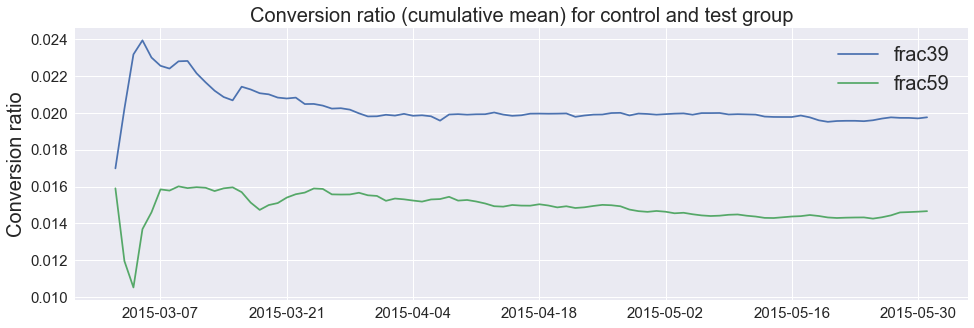

In [226]:
plt.figure(figsize=(16,5))
plt.plot(df.day, df.frac39)
plt.plot(df.day, df.frac59)
plt.title("Conversion ratio (cumulative mean) for control and test group", fontsize=20)
plt.ylabel("Conversion ratio", fontsize=20)
plt.tick_params(labelsize=15)
plt.legend(fontsize=20)

## Conclusions:

1. The conversion rate for mac/ios users is higher than other operating systems such as windows/linux/other for both the control and test groups.


2. For control group, the web(PC) users convert faster than the mobile users, but opposite is true for test group with mobile users converting at siginificantly rate than web(PC) users


3. The conversion ratio is highest if the source is friend referral for both control and test group


4. Direct traffic and bing ads have lowest some of the lowest rate of converting. 


5. Within the search engine optimization sources, google-seo has one of the lowest rate of conversion in control group, but suprisingly the google-seo has highest conversion rate in test group. 


6. From the above plot we can conclude that the **after about three weeks we can stop the test** as the conversion ratio becomes  stable and doesn't change much for both control and test groups


## Recommendations:

1. Focus more on improving conversion rate for non-mac users (linux windows) via ads campaigns etc.

2. In general, more targeted marketing for non-google users will help improve the conversion ratio
